## REVENUE PROPERTY MANAGEMENT

### ETL

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Importar SARIMAX
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Leemos los datasets
meta=pd.read_excel('Metas_Mensuales&Ocupacion.xlsx')
propiedad=pd.read_excel('Propiedades.xlsx')
reserva=pd.read_excel('Reservas.xlsx')

In [3]:
# Visualizamos los datasets
meta.sample(3)

,PropertyId,Date,RevenueGoal,BookedDays,AvailableDays
336,43411,2024-01-01,2894.48,21,31
567,43320,2024-04-01,8911.34,20,24
746,43286,2024-03-01,3498.07,29,31


In [4]:
# Obtenemos mayor información de cada dataset
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PropertyId     948 non-null    int64         
 1   Date           948 non-null    datetime64[ns]
 2   RevenueGoal    948 non-null    float64       
 3   BookedDays     948 non-null    int64         
 4   AvailableDays  948 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 37.2 KB


In [5]:
# Vemos si hay valores nulos
meta.isnull().sum()

PropertyId       0
Date             0
RevenueGoal      0
BookedDays       0
AvailableDays    0
dtype: int64

In [6]:
propiedad.sample(3)

,PropertyId,ReadyDate,Region,Province,Capacity,NumBedrooms,Square,AutoCheckin
35,43395,2023-03-08,Catalunya,Barcelona,6,3,130,0
20,43421,2023-05-28,Catalunya,Barcelona,7,4,90,0
66,43284,2022-05-11,Catalunya,Barcelona,2,1,40,1


In [7]:
propiedad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   PropertyId   79 non-null     int64         
 1   ReadyDate    79 non-null     datetime64[ns]
 2   Region       79 non-null     object        
 3   Province     79 non-null     object        
 4   Capacity     79 non-null     int64         
 5   NumBedrooms  79 non-null     int64         
 6   Square       79 non-null     int64         
 7   AutoCheckin  79 non-null     int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 5.1+ KB


In [8]:
propiedad.isnull().sum()

PropertyId     0
ReadyDate      0
Region         0
Province       0
Capacity       0
NumBedrooms    0
Square         0
AutoCheckin    0
dtype: int64

In [9]:
reserva.sample(3)

,BookingId,PropertyId,BookingCreatedDate,ArrivalDate,DepartureDate,NumNights,TotalPrice,ChannelComission,Channel
2321,125841,43303,2023-08-21 18:03:47,2023-10-06,2023-10-10,4,740.16,111.02,6
6817,148907,43267,2024-07-22 18:57:51,2024-07-30,2024-08-01,2,415.50,62.32,6
6349,145879,43312,2024-06-22 20:31:31,2024-07-12,2024-07-15,3,574.60,86.19,6


In [10]:
reserva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8499 entries, 0 to 8498
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   BookingId           8499 non-null   int64         
 1   PropertyId          8499 non-null   int64         
 2   BookingCreatedDate  8499 non-null   datetime64[ns]
 3   ArrivalDate         8499 non-null   datetime64[ns]
 4   DepartureDate       8499 non-null   datetime64[ns]
 5   NumNights           8499 non-null   int64         
 6   TotalPrice          8499 non-null   float64       
 7   ChannelComission    8499 non-null   float64       
 8   Channel             8499 non-null   int64         
dtypes: datetime64[ns](3), float64(2), int64(4)
memory usage: 597.7 KB


In [11]:
# Observamos algunas estadísticas descriptivas para ver si hay algún patrón
reserva.describe()

,BookingId,PropertyId,BookingCreatedDate,ArrivalDate,DepartureDate,NumNights,TotalPrice,ChannelComission,Channel
count,8499.000000,8499.000000,8499,8499,8499,8499.000000,8499.000000,8499.000000,8499.000000
mean,135121.756089,43357.999412,2024-01-11 04:23:24.378867968,2024-02-12 15:20:56.936110336,2024-02-17 14:19:19.195199232,4.962349,1038.739244,158.498432,5.320861
min,106159.000000,43267.000000,2022-08-11 13:55:20,2023-01-02 00:00:00,2023-01-05 00:00:00,1.000000,0.010000,0.000000,1.000000
25%,124883.000000,43305.000000,2023-08-06 08:21:51,2023-09-09 00:00:00,2023-09-14 00:00:00,3.000000,604.495000,91.480000,4.000000
50%,133985.000000,43348.000000,2024-01-24 15:51:34,2024-02-26 00:00:00,2024-03-03 00:00:00,4.000000,877.870000,134.770000,6.000000
75%,146048.500000,43415.000000,2024-06-24 11:34:55.500000,2024-07-26 12:00:00,2024-07-31 12:00:00,6.000000,1302.425000,201.295000,6.000000
max,162004.000000,43467.000000,2024-12-30 18:45:27,2024-12-31 00:00:00,2025-01-08 00:00:00,140.000000,13865.000000,1868.020000,6.000000
std,13105.554484,56.684048,NaN,NaN,NaN,3.851839,678.431545,104.902091,1.028999


In [12]:
reserva.isnull().sum()

BookingId             0
PropertyId            0
BookingCreatedDate    0
ArrivalDate           0
DepartureDate         0
NumNights             0
TotalPrice            0
ChannelComission      0
Channel               0
dtype: int64

In [13]:
# Contamos duplicados por columna
resumen_duplicados = reserva.apply(lambda col: col.duplicated(keep=False).sum()).to_frame(name='Duplicados')
resumen_duplicados['Porcentaje'] = (reserva.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(2)
resumen_duplicados['Total Filas'] = len(reserva)

print(resumen_duplicados)

                    Duplicados  Porcentaje  Total Filas
BookingId                    0        0.00         8499
PropertyId                8499      100.00         8499
BookingCreatedDate           2        0.02         8499
ArrivalDate               8387       98.68         8499
DepartureDate             8436       99.26         8499
NumNights                 8486       99.85         8499
TotalPrice                 792        9.32         8499
ChannelComission          2670       31.42         8499
Channel                   8499      100.00         8499


In [14]:
resumen_unicos = reserva.nunique().to_frame(name='Valores Únicos')
resumen_unicos['Porcentaje'] = (reserva.nunique() / len(reserva) * 100).round(2)
resumen_unicos['Total Filas'] = len(reserva)

print(resumen_unicos)

                    Valores Únicos  Porcentaje  Total Filas
BookingId                     8499      100.00         8499
PropertyId                      79        0.93         8499
BookingCreatedDate            8498       99.99         8499
ArrivalDate                    836        9.84         8499
DepartureDate                  793        9.33         8499
NumNights                       45        0.53         8499
TotalPrice                    8067       94.92         8499
ChannelComission              6949       81.76         8499
Channel                          4        0.05         8499


In [15]:
# Agregamos una columna de mes en reservas
reserva['Month'] = reserva['ArrivalDate'].dt.month

#### -----------------------------------------------------------------

1. Análisis descriptivo de indicadores
   
●	Calcular KPIs como ADR, RevPAR, ocupación y Revenue mensual para cada propiedad.

In [16]:
# Calculamos el revenue neto en reservas
reserva['NetRevenue'] = reserva['TotalPrice'] - reserva['ChannelComission']

In [17]:
# Agrupamos las reservas por propiedad y mes
reservas_agrupadas = reserva.groupby(['PropertyId', 'Month']).agg(
    Revenue=('NetRevenue', 'sum'),
    Habitaciones_Vendidas=('NumNights', 'sum')  # Asumimos 1 noche = 1 habitación vendida
).reset_index()

In [18]:
# Agregamos los datos de metas y ocupación
meta['Month'] = meta['Date'].dt.month
kpi_data = pd.merge(meta, reservas_agrupadas, on=['PropertyId', 'Month'], how='left')

In [19]:
# ADR
kpi_data['ADR'] = kpi_data['Revenue'] / kpi_data['Habitaciones_Vendidas']

In [20]:
# RevPar
kpi_data['RevPAR'] = kpi_data['Revenue'] / kpi_data['AvailableDays']

In [21]:
# Ocupación
kpi_data['Ocupación (%)'] = (kpi_data['BookedDays'] / kpi_data['AvailableDays']) * 100

In [22]:
# Completamos los datos con propiedades
resultado_final = pd.merge(kpi_data, propiedad, on='PropertyId', how='left')

In [23]:
# Mostramos los resultados
print(resultado_final[['PropertyId', 'Month', 'RevenueGoal', 'Revenue', 'ADR', 'RevPAR', 'Ocupación (%)', 'Region', 'Province']])

     PropertyId  Month  RevenueGoal   Revenue         ADR      RevPAR   
0         43467      1      1525.00   1327.36   53.094400   42.818065  \
1         43467      2      1361.00   1261.94   70.107778   43.515172   
2         43467      3      1637.00   1931.07   68.966786   62.292581   
3         43467      4      3105.00   2746.04   65.381905   91.534667   
4         43467      5      2953.00    516.19   73.741429   16.651290   
..          ...    ...          ...       ...         ...         ...   
943       43408      8      8940.41   7173.25  224.164062  231.395161   
944       43408      9      7560.74  16521.09  115.532098  550.703000   
945       43408     10      8554.46   5613.65  207.912963  181.085484   
946       43408     11      5172.82   3474.96  124.105714  115.832000   
947       43408     12      5235.01   6600.94  153.510233  212.933548   

     Ocupación (%)     Region   Province  
0        80.645161  Andalucía     Málaga  
1        79.310345  Andalucía     Mál

In [24]:
resultado_final.head(15)

,PropertyId,Date,RevenueGoal,BookedDays,AvailableDays,Month,Revenue,Habitaciones_Vendidas,ADR,RevPAR,Ocupación (%),ReadyDate,Region,Province,Capacity,NumBedrooms,Square,AutoCheckin
0,43467,2024-01-01,1525.0,25,31,1,1327.36,25.0,53.094400,42.818065,80.645161,2023-11-15,Andalucía,Málaga,4,1,50,1
1,43467,2024-02-01,1361.0,23,29,2,1261.94,18.0,70.107778,43.515172,79.310345,2023-11-15,Andalucía,Málaga,4,1,50,1
2,43467,2024-03-01,1637.0,25,31,3,1931.07,28.0,68.966786,62.292581,80.645161,2023-11-15,Andalucía,Málaga,4,1,50,1
3,43467,2024-04-01,3105.0,22,30,4,2746.04,42.0,65.381905,91.534667,73.333333,2023-11-15,Andalucía,Málaga,4,1,50,1
4,43467,2024-05-01,2953.0,30,31,5,516.19,7.0,73.741429,16.651290,96.774194,2023-11-15,Andalucía,Málaga,4,1,50,1
5,43467,2024-06-01,3552.0,27,30,6,2615.18,34.0,76.917059,87.172667,90.000000,2023-11-15,Andalucía,Málaga,4,1,50,1
6,43467,2024-07-01,4269.0,26,31,7,2534.22,26.0,97.470000,81.749032,83.870968,2023-11-15,Andalucía,Málaga,4,1,50,1
7,43467,2024-08-01,4715.0,28,31,8,2817.59,23.0,122.503913,90.890000,90.322581,2023-11-15,Andalucía,Málaga,4,1,50,1
8,43467,2024-09-01,2688.0,29,30,9,2030.72,29.0,70.024828,67.690667,96.666667,2023-11-15,Andalucía,Málaga,4,1,50,1
9,43467,2024-10-01,2046.0,27,31,10,1912.91,31.0,61.706774,61.706774,87.096774,2023-11-15,Andalucía,Málaga,4,1,50,1


●	Comparar el rendimiento mensual con las metas.

In [25]:
# Agregamos una columna de diferencia entre Revenue real y RevenueGoal
resultado_final['Diferencia_Revenue'] = resultado_final['Revenue'] - resultado_final['RevenueGoal']

In [26]:
# Agregamos el porcentaje de cumplimiento de la meta de Revenue
resultado_final['Cumplimiento_Revenue (%)'] = (resultado_final['Revenue'] / resultado_final['RevenueGoal']) * 100

In [27]:
# Identificamos si se cumplió la meta de Revenue
resultado_final['Meta_Cumplida'] = resultado_final['Cumplimiento_Revenue (%)'] >= 100

In [28]:
print(resultado_final[['PropertyId', 'Month', 'RevenueGoal', 'Revenue', 
                       'Diferencia_Revenue', 'Cumplimiento_Revenue (%)', 'Meta_Cumplida']])


     PropertyId  Month  RevenueGoal   Revenue  Diferencia_Revenue   
0         43467      1      1525.00   1327.36             -197.64  \
1         43467      2      1361.00   1261.94              -99.06   
2         43467      3      1637.00   1931.07              294.07   
3         43467      4      3105.00   2746.04             -358.96   
4         43467      5      2953.00    516.19            -2436.81   
..          ...    ...          ...       ...                 ...   
943       43408      8      8940.41   7173.25            -1767.16   
944       43408      9      7560.74  16521.09             8960.35   
945       43408     10      8554.46   5613.65            -2940.81   
946       43408     11      5172.82   3474.96            -1697.86   
947       43408     12      5235.01   6600.94             1365.93   

     Cumplimiento_Revenue (%)  Meta_Cumplida  
0                   87.040000          False  
1                   92.721528          False  
2                  117.963958 

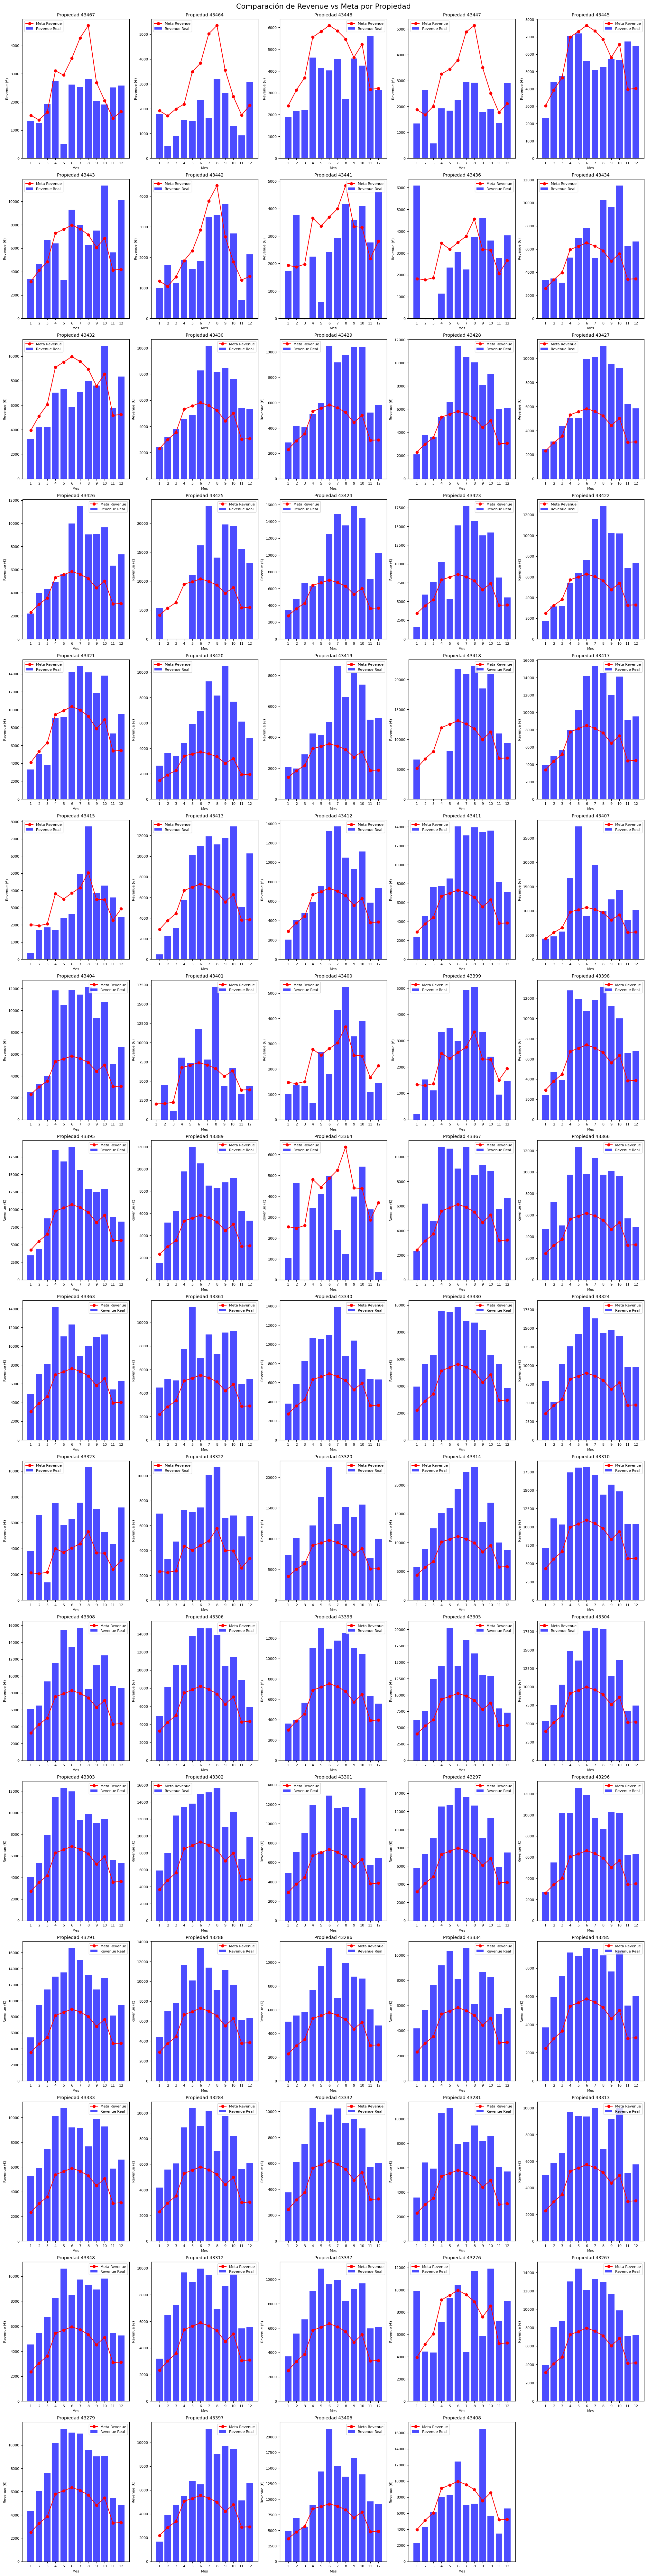

In [29]:
# Número total de propiedades
num_properties = resultado_final['PropertyId'].nunique()

# Configuración de subplots: 5 columnas
cols = 5
rows = (num_properties // cols) + (num_properties % cols > 0)  # Calcula el número de filas necesarias

# Crear figura y subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), constrained_layout=True)

# Asegurarse de que sea un arreglo plano
axes = axes.flatten()

# Iterar por cada propiedad y crear gráficos
for idx, property_id in enumerate(resultado_final['PropertyId'].unique()):
    df_property = resultado_final[resultado_final['PropertyId'] == property_id]
    ax = axes[idx]
    
    # Gráfico de barras y línea
    ax.bar(df_property['Month'].astype(str), df_property['Revenue'], label='Revenue Real', color='blue', alpha=0.7)
    ax.plot(df_property['Month'].astype(str), df_property['RevenueGoal'], label='Meta Revenue', color='red', marker='o')
    
    # Títulos y etiquetas
    ax.set_title(f'Propiedad {property_id}', fontsize=10)
    ax.set_xlabel('Mes', fontsize=8)
    ax.set_ylabel('Revenue (€)', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(fontsize=8)

# Eliminar subplots vacíos si hay menos propiedades que subplots
for idx in range(len(resultado_final['PropertyId'].unique()), len(axes)):
    fig.delaxes(axes[idx])

# Título general de la figura
fig.suptitle('Comparación de Revenue vs Meta por Propiedad', fontsize=16)

# Mostrar figura
plt.show()


●	Identificar las 10 propiedades con mejor rendimiento y las 10 con peor rendimiento en 2024.

In [30]:
resultado_final['Year'] = pd.to_datetime(resultado_final['Date']).dt.year

In [31]:
# Filtramos los datos para 2024
datos_2024 = resultado_final[resultado_final['Year'] == 2024]

# Calculamos el rendimiento total anual para cada propiedad
rendimiento_anual = datos_2024.groupby('PropertyId').agg({
    'Revenue': 'sum',  # Suma de ingresos reales
    'RevenueGoal': 'sum',  # Suma de metas
    'Cumplimiento_Revenue (%)': 'mean'  # Promedio de cumplimiento de metas
}).reset_index()

# Calculamos la diferencia anual entre Revenue y RevenueGoal
rendimiento_anual['Diferencia_Revenue_Total'] = rendimiento_anual['Revenue'] - rendimiento_anual['RevenueGoal']

# Ordenamos las propiedades por rendimiento
mejores_propiedades = rendimiento_anual.sort_values(by='Revenue', ascending=False).head(10)
peores_propiedades = rendimiento_anual.sort_values(by='Revenue', ascending=True).head(10)

In [32]:
# Visualizamos las 10 mejores propiedades según su Revenue
mejores_propiedades

,PropertyId,Revenue,RevenueGoal,Cumplimiento_Revenue (%),Diferencia_Revenue_Total
21,43314,171978.88,98753.76,170.654437,73225.12
18,43310,164940.44,97053.08,171.476382,67887.36
15,43305,151178.50,91115.46,163.629402,60063.04
22,43320,147774.47,86951.03,169.933024,60823.44
25,43324,146825.77,79849.01,185.329181,66976.76
14,43304,144112.97,88779.15,158.445177,55333.82
48,43407,142260.40,95402.00,143.682772,46858.40
40,43395,141987.32,95402.00,142.829097,46585.32
47,43406,140607.44,82359.01,168.332974,58248.43
12,43302,140377.45,82753.61,170.970882,57623.84


In [33]:
# Visualizamos las 10 peores propiedades según su Revenue
peores_propiedades

,PropertyId,Revenue,RevenueGoal,Cumplimiento_Revenue (%),Diferencia_Revenue_Total
77,43464,21355.53,35436.00,63.178089,-14080.47
75,43447,24357.44,35980.00,73.820282,-11622.56
78,43467,24786.07,30928.00,91.503258,-6141.93
72,43442,25239.35,26018.00,102.043279,-778.65
44,43400,28119.76,28086.00,95.689100,33.76
43,43399,30771.72,25504.01,111.103520,5267.71
71,43441,32878.36,36956.01,101.417433,-4077.65
70,43436,33374.31,34902.99,120.805837,-1528.68
35,43364,34915.08,48636.00,75.108499,-13720.92
53,43415,37449.60,38553.01,93.552357,-1103.41


#### 2. Predicción de comportamientos

●	Seleccionar las 3 propiedades más antiguas de las 10 con mejor rendimiento en 2024.

In [34]:
# Filtramos los datos para 2024
datos_2024 = resultado_final[resultado_final['Year'] == 2024]

# Calculamos el rendimiento total anual para cada propiedad
rendimiento_anual = datos_2024.groupby('PropertyId').agg({
    'Revenue': 'sum',  # Suma de ingresos reales
    'RevenueGoal': 'sum',  # Suma de metas
    'Cumplimiento_Revenue (%)': 'mean'  # Promedio de cumplimiento de metas
}).reset_index()

# Calculamos la diferencia anual entre Revenue y RevenueGoal
rendimiento_anual['Diferencia_Revenue_Total'] = rendimiento_anual['Revenue'] - rendimiento_anual['RevenueGoal']

# Ordenamos propiedades por rendimiento (Top 10 mejores propiedades)
mejores_propiedades = rendimiento_anual.sort_values(by='Revenue', ascending=False).head(10)

# Cargamos la tabla de Propiedades y convertir ReadyDate a formato datetime
propiedad['ReadyDate'] = pd.to_datetime(propiedad['ReadyDate'])

# Unimos las 10 mejores propiedades con la tabla de propiedades para obtener ReadyDate
top_10_mejores = pd.merge(mejores_propiedades, propiedad[['PropertyId', 'ReadyDate']], on='PropertyId', how='left')

# Ordenamos por antigüedad (ReadyDate) y seleccionar las 3 propiedades más antiguas
top_3_antiguas = top_10_mejores.sort_values(by='ReadyDate', ascending=True).head(3)

In [35]:
# Visualizamos las 3 propiedades más antiguas
top_3_antiguas

,PropertyId,Revenue,RevenueGoal,Cumplimiento_Revenue (%),Diferencia_Revenue_Total,ReadyDate
5,43304,144112.97,88779.15,158.445177,55333.82,2022-05-17
2,43305,151178.50,91115.46,163.629402,60063.04,2022-05-18
9,43302,140377.45,82753.61,170.970882,57623.84,2022-05-25


●	Estimar ocupación, ADR y RevPAR para los próximos 3 meses.

In [36]:
# Aseguramos que las fechas estén en formato datetime
reserva['ArrivalDate'] = pd.to_datetime(reserva['ArrivalDate'])
reserva['DepartureDate'] = pd.to_datetime(reserva['DepartureDate'])

# Extraemos el año y mes de la fecha de llegada
reserva['Year'] = reserva['ArrivalDate'].dt.year
reserva['Month'] = reserva['ArrivalDate'].dt.month

# Agrupamos por PropertyId, Año y Mes
resumen_mensual = reserva.groupby(['PropertyId', 'Year', 'Month']).agg({
    'NumNights': 'sum',         # Total de noches reservadas (ocupación)
    'NetRevenue': 'sum'         # Total de ingresos netos (revenue)
}).reset_index()

# Agregamos número de habitaciones por propiedad desde el DataFrame propiedades
resumen_mensual = resumen_mensual.merge(
    propiedad[['PropertyId', 'NumBedrooms']].drop_duplicates(),
    on='PropertyId',
    how='left'
)

# Calculamos los días disponibles en el mes considerando todas las habitaciones
resumen_mensual['AvailableDays'] = 30 * resumen_mensual['NumBedrooms']

# Calculamos la Ocupación (%) de forma precisa
resumen_mensual['Ocupación (%)'] = (resumen_mensual['NumNights'] / resumen_mensual['AvailableDays']) * 100

# Calculamos el RevPAR (Revenue por habitación disponible)
resumen_mensual['RevPAR'] = resumen_mensual['NetRevenue'] / resumen_mensual['AvailableDays']

# Renombramos NetRevenue a Revenue por consistencia
resumen_mensual.rename(columns={'NetRevenue': 'Revenue'}, inplace=True)

# Verificamos el resultado
print(resumen_mensual.head())


   PropertyId  Year  Month  NumNights  Revenue  NumBedrooms  AvailableDays   
0       43267  2023      1         17  1735.95            2             60  \
1       43267  2023      2         27  3562.20            2             60   
2       43267  2023      3         28  4236.52            2             60   
3       43267  2023      4         30  6495.91            2             60   
4       43267  2023      5         29  7479.51            2             60   

   Ocupación (%)      RevPAR  
0      28.333333   28.932500  
1      45.000000   59.370000  
2      46.666667   70.608667  
3      50.000000  108.265167  
4      48.333333  124.658500  


In [37]:
# IDs de las propiedades más antiguas
ids_antiguas = [43304, 43305, 43302]

# Filtramos el resumen solo con esas propiedades
resumen_antiguas = resumen_mensual[resumen_mensual['PropertyId'].isin(ids_antiguas)].copy()

# Entrenamos los modelos
X = resumen_antiguas[['PropertyId', 'Year', 'Month']]
y_revenue = resumen_antiguas['Revenue']
y_occupancy = resumen_antiguas['Ocupación (%)']
y_revpar = resumen_antiguas['RevPAR']

model_revenue = RandomForestRegressor(random_state=42)
model_occupancy = RandomForestRegressor(random_state=42)
model_revpar = RandomForestRegressor(random_state=42)

model_revenue.fit(X, y_revenue)
model_occupancy.fit(X, y_occupancy)
model_revpar.fit(X, y_revpar)

# Creamos nuevas fechas (enero a marzo 2025)
future_rows = pd.DataFrame([
    {'PropertyId': pid, 'Year': 2025, 'Month': mes}
    for pid in ids_antiguas for mes in [1, 2, 3]
])

# Predecimos los valores para cada métrica (usando solo columnas válidas)
X_future = future_rows[['PropertyId', 'Year', 'Month']]
future_rows['Revenue'] = model_revenue.predict(X_future)
future_rows['Ocupación (%)'] = pd.Series(model_occupancy.predict(X_future)).clip(lower=0, upper=100)
future_rows['RevPAR'] = model_revpar.predict(X_future)

# Agregamos columnas constantes para las nuevas filas
future_rows['AvailableDays'] = 30
future_rows['NumNights'] = (future_rows['Ocupación (%)'] / 100 * 30).round()

# Unimos el forecast con el histórico
forecast_completo = pd.concat([resumen_antiguas, future_rows], ignore_index=True).sort_values(by=['PropertyId', 'Year', 'Month'])

# Vemos el resultado
print(forecast_completo)

    PropertyId  Year  Month  NumNights    Revenue  NumBedrooms  AvailableDays   
0        43302  2023      1       27.0  2904.3800          3.0             90  \
1        43302  2023      2       24.0  3750.5400          3.0             90   
2        43302  2023      3       32.0  6170.2200          3.0             90   
3        43302  2023      4       23.0  5877.7300          3.0             90   
4        43302  2023      5       24.0  6504.8700          3.0             90   
..         ...   ...    ...        ...        ...          ...            ...   
70       43305  2024     11       23.0  3346.6800          3.0             90   
71       43305  2024     12       23.0  3410.8200          3.0             90   
75       43305  2025      1        8.0  2928.5074          NaN             30   
76       43305  2025      2        8.0  4065.2529          NaN             30   
77       43305  2025      3        9.0  6055.3080          NaN             30   

    Ocupación (%)     RevPA

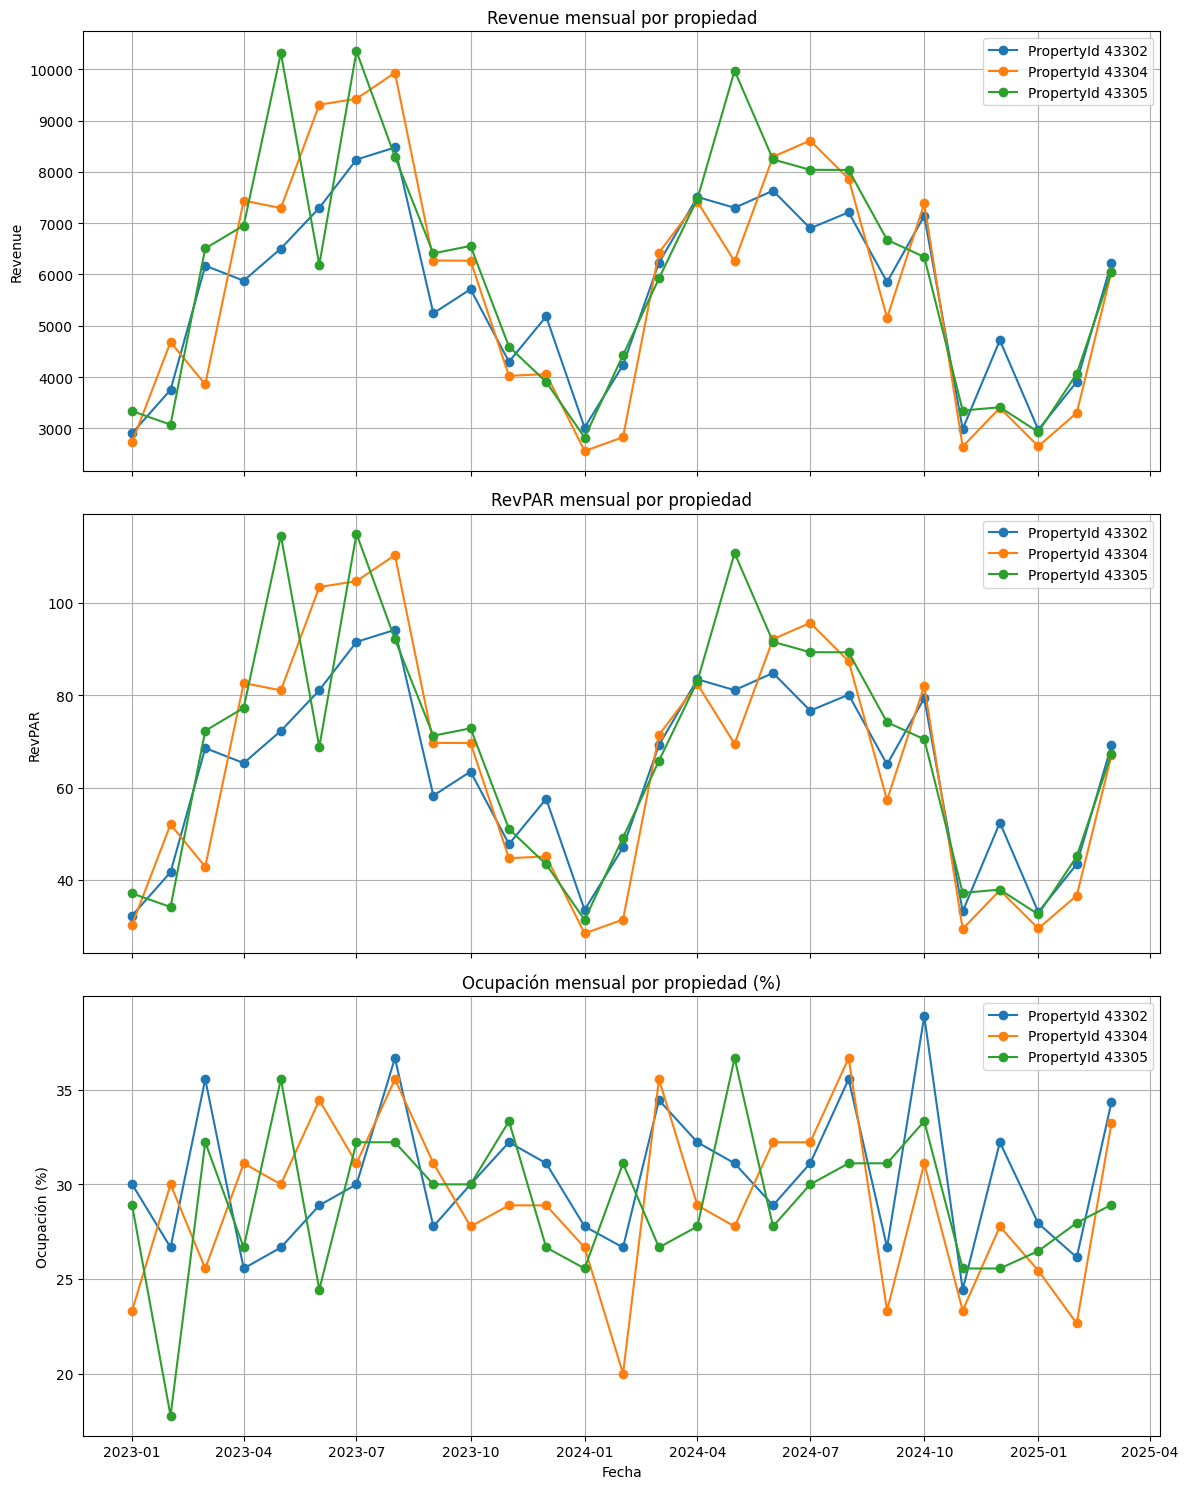

In [38]:
# Aseguramos el orden por fechas
forecast_completo = forecast_completo.sort_values(by=['PropertyId', 'Year', 'Month'])

# Crear una columna de fecha combinada para el eje X
forecast_completo['Fecha'] = pd.to_datetime(forecast_completo[['Year', 'Month']].assign(DAY=1))

# Crear figura con 3 subplots verticales
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Lista de métricas a graficar
metricas = ['Revenue', 'RevPAR', 'Ocupación (%)']
titulos = ['Revenue mensual por propiedad', 'RevPAR mensual por propiedad', 'Ocupación mensual por propiedad (%)']

# Graficar cada métrica
for i, metrica in enumerate(metricas):
    for pid in forecast_completo['PropertyId'].unique():
        data_prop = forecast_completo[forecast_completo['PropertyId'] == pid]
        axes[i].plot(data_prop['Fecha'], data_prop[metrica], label=f'PropertyId {pid}', marker='o')

    axes[i].set_title(titulos[i])
    axes[i].set_ylabel(metrica)
    axes[i].legend()
    axes[i].grid(True)

# Ajustes finales
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


●	Incorporar una variable externa (como eventos o estacionalidad) para enriquecer el análisis.(OPCIONAL)

In [39]:
# Definimos algunos eventos importantes en España
eventos_data = {
    'Date': [
        '2024-03-29',  # Semana Santa
        '2024-04-01',  # Semana Santa
        '2024-06-15',  # Fiestas de San Fermín (Pamplona)
        '2024-08-15',  # Fiesta Nacional de la Asunción
        '2024-10-12',  # Día de la Hispanidad
        '2024-12-24',  # Nochebuena
        '2024-12-31',  # Nochevieja
        '2024-02-24',  # Carnival en Tenerife
        '2024-06-22',  # MWC Barcelona (feria tecnológica)
        '2024-07-05'   # San Sebastián Jazzaldia
    ],
    'Evento': [
        'Semana Santa',
        'Semana Santa',
        'San Fermín',
        'Fiesta Nacional de la Asunción',
        'Día de la Hispanidad',
        'Nochebuena',
        'Nochevieja',
        'Carnival Tenerife',
        'MWC Barcelona',
        'Jazzaldia San Sebastián'
    ],
    'Region': [
        'Nacional',  # Afecta a toda España
        'Nacional',
        'Navarra',  # Afecta principalmente a Pamplona
        'Nacional',
        'Nacional',
        'Nacional',
        'Nacional',
        'Canarias',  # Afecta principalmente a Tenerife
        'Cataluña',  # Afecta principalmente a Barcelona
        'País Vasco'  # Afecta principalmente a San Sebastián
    ]
}

# Convertimos a DataFrame
eventos_df = pd.DataFrame(eventos_data)

# Convertimos la columna 'Date' a tipo datetime
eventos_df['Date'] = pd.to_datetime(eventos_df['Date'])

# Mostramos el DataFrame
print(eventos_df)

        Date                          Evento      Region
0 2024-03-29                    Semana Santa    Nacional
1 2024-04-01                    Semana Santa    Nacional
2 2024-06-15                      San Fermín     Navarra
3 2024-08-15  Fiesta Nacional de la Asunción    Nacional
4 2024-10-12            Día de la Hispanidad    Nacional
5 2024-12-24                      Nochebuena    Nacional
6 2024-12-31                      Nochevieja    Nacional
7 2024-02-24               Carnival Tenerife    Canarias
8 2024-06-22                   MWC Barcelona    Cataluña
9 2024-07-05         Jazzaldia San Sebastián  País Vasco


In [40]:
# Procesamos el resumen mensual desde DataFrame `reserva` ---
reserva['ArrivalDate'] = pd.to_datetime(reserva['ArrivalDate'])
reserva['DepartureDate'] = pd.to_datetime(reserva['DepartureDate'])
reserva['Year'] = reserva['ArrivalDate'].dt.year
reserva['Month'] = reserva['ArrivalDate'].dt.month

resumen_mensual = reserva.groupby(['PropertyId', 'Year', 'Month']).agg({
    'NumNights': 'sum',
    'NetRevenue': 'sum'
}).reset_index()

resumen_mensual['AvailableDays'] = 30
resumen_mensual['Ocupación (%)'] = (resumen_mensual['NumNights'] / resumen_mensual['AvailableDays']) * 100
resumen_mensual['RevPAR'] = resumen_mensual['NetRevenue'] / resumen_mensual['AvailableDays']
resumen_mensual.rename(columns={'NetRevenue': 'Revenue'}, inplace=True)

# Agregamos una columna Fecha
resumen_mensual['Fecha'] = pd.to_datetime(resumen_mensual[['Year', 'Month']].assign(DAY=1))

eventos_df = pd.DataFrame(eventos_data)
eventos_df['Date'] = pd.to_datetime(eventos_df['Date'])
eventos_df['Year'] = eventos_df['Date'].dt.year
eventos_df['Month'] = eventos_df['Date'].dt.month
eventos_df['Fecha'] = pd.to_datetime(eventos_df[['Year', 'Month']].assign(DAY=1))

# Creamos indicadores mensual de evento
eventos_mensuales = eventos_df[['Fecha']].drop_duplicates()
eventos_mensuales['EventoPresente'] = 1

# Unimos eventos al histórico
forecast_completo = resumen_mensual.merge(eventos_mensuales, on='Fecha', how='left')
forecast_completo['EventoPresente'] = forecast_completo['EventoPresente'].fillna(0)

# Filtramos las propiedades más antiguas 
ids_antiguas = [43304, 43305, 43302]
forecast_completo = forecast_completo[forecast_completo['PropertyId'].isin(ids_antiguas)]

# Creamos los datos de predicción para el 2025
future_rows = pd.DataFrame([
    {'PropertyId': pid, 'Year': 2025, 'Month': mes}
    for pid in ids_antiguas for mes in range(1, 13)
])
future_rows['Fecha'] = pd.to_datetime(future_rows[['Year', 'Month']].assign(DAY=1))
future_rows = future_rows.merge(eventos_mensuales, on='Fecha', how='left')
future_rows['EventoPresente'] = future_rows['EventoPresente'].fillna(0)

# Entrenamos los modelos con la variable de evento 
features = ['PropertyId', 'Year', 'Month', 'EventoPresente']
X = forecast_completo[features]
y_revenue = forecast_completo['Revenue']
y_occupancy = forecast_completo['Ocupación (%)']
y_revpar = forecast_completo['RevPAR']

model_revenue = RandomForestRegressor(random_state=42)
model_occupancy = RandomForestRegressor(random_state=42)
model_revpar = RandomForestRegressor(random_state=42)

model_revenue.fit(X, y_revenue)
model_occupancy.fit(X, y_occupancy)
model_revpar.fit(X, y_revpar)

# Predecimos para 2025 
X_future = future_rows[features]
future_rows['Revenue'] = model_revenue.predict(X_future)
future_rows['Ocupación (%)'] = pd.Series(model_occupancy.predict(X_future)).clip(lower=0, upper=100)
future_rows['RevPAR'] = model_revpar.predict(X_future)
future_rows['AvailableDays'] = 30
future_rows['NumNights'] = (future_rows['Ocupación (%)'] / 100 * 30).round()

# Unimos con histórico y ordenamos
forecast_final = pd.concat([forecast_completo, future_rows], ignore_index=True)
forecast_final = forecast_final.sort_values(by=['PropertyId', 'Year', 'Month'])

# Visualizamos el resultado final
print(forecast_final[['PropertyId', 'Year', 'Month', 'Revenue', 'Ocupación (%)', 'RevPAR', 'EventoPresente']])

    PropertyId  Year  Month    Revenue  Ocupación (%)      RevPAR   
0        43302  2023      1  2904.3800      90.000000   96.812667  \
1        43302  2023      2  3750.5400      80.000000  125.018000   
2        43302  2023      3  6170.2200     106.666667  205.674000   
3        43302  2023      4  5877.7300      76.666667  195.924333   
4        43302  2023      5  6504.8700      80.000000  216.829000   
..         ...   ...    ...        ...            ...         ...   
91       43305  2025      8  8455.2084      96.855556  280.343423   
92       43305  2025      9  6393.4980      87.500000  212.460763   
93       43305  2025     10  6472.3791      88.866667  215.090133   
94       43305  2025     11  3197.3575      77.300000  106.923960   
95       43305  2025     12  3348.4336      77.833333  111.920370   

    EventoPresente  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
..             ...  
91             0.0  
92 

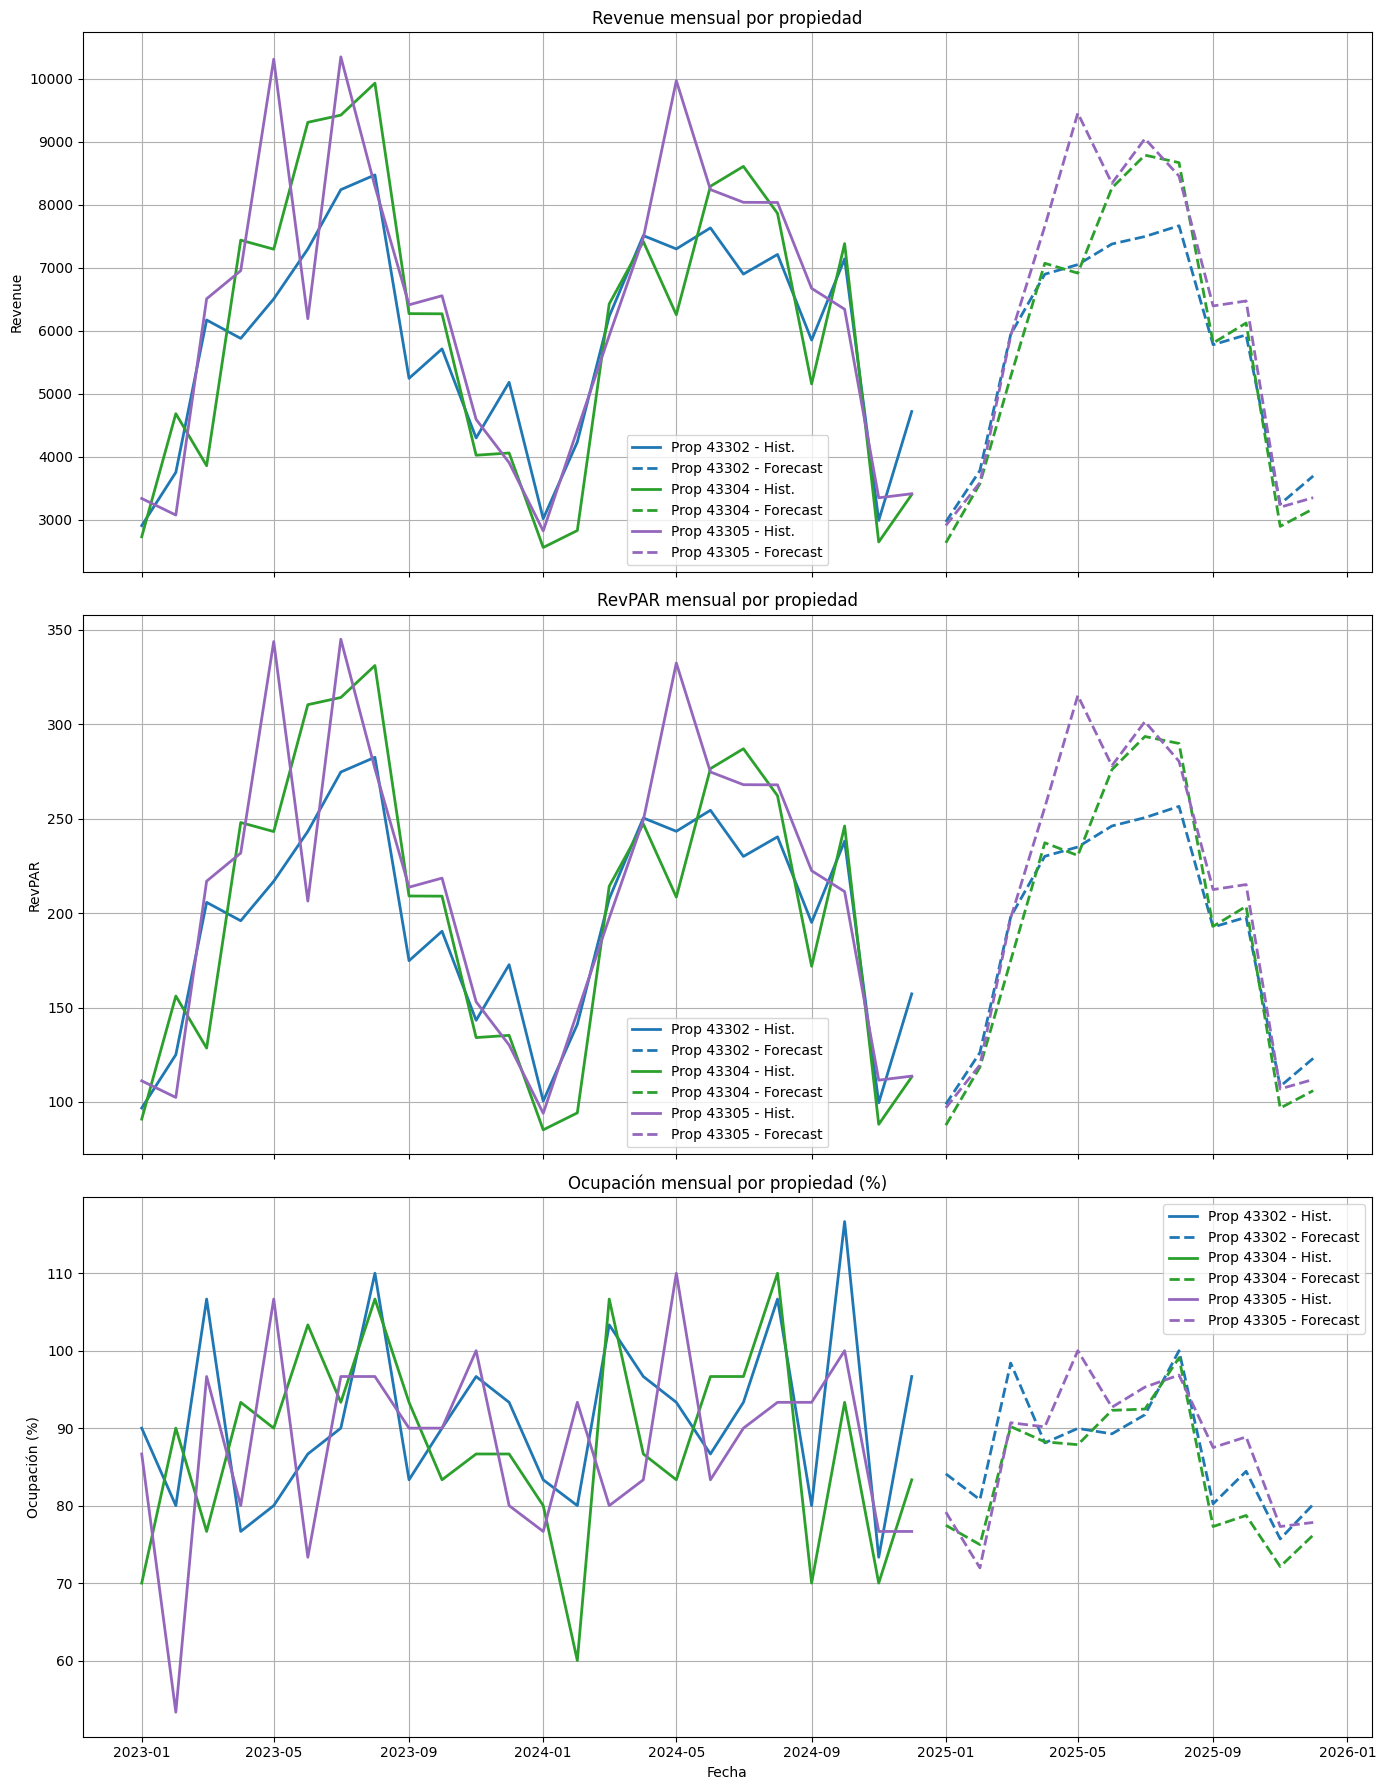

In [41]:
# Aseguramos orden por fecha
forecast_final = forecast_final.sort_values(by=['PropertyId', 'Year', 'Month'])
forecast_final['Fecha'] = pd.to_datetime(forecast_final[['Year', 'Month']].assign(DAY=1))

# Creamos figura
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Definimos métricas
metricas = ['Revenue', 'RevPAR', 'Ocupación (%)']
titulos = ['Revenue mensual por propiedad', 'RevPAR mensual por propiedad', 'Ocupación mensual por propiedad (%)']
colores = {43302: 'tab:blue', 43304: 'tab:green', 43305: 'tab:purple'}  # asignar color por ID

# Graficamos
for i, metrica in enumerate(metricas):
    ax = axes[i]
    for pid in forecast_final['PropertyId'].unique():
        datos_prop = forecast_final[forecast_final['PropertyId'] == pid]
        historico = datos_prop[datos_prop['Year'] < 2025]
        forecast = datos_prop[datos_prop['Year'] == 2025]

        # Histórico: línea sólida
        ax.plot(historico['Fecha'], historico[metrica],
                label=f'Prop {pid} - Hist.', color=colores[pid], linewidth=2)

        # Forecast: misma línea pero punteada
        ax.plot(forecast['Fecha'], forecast[metrica],
                linestyle='--', label=f'Prop {pid} - Forecast', color=colores[pid], linewidth=2)

    ax.set_title(titulos[i])
    ax.set_ylabel(metrica)
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()



Análisis de elasticidad de precios

●	Seleccionar 2 propiedades con peor rendimiento de las 10 con peor rendimiento en 2024.

●	Determinar cómo cambiarían ocupación y RevPAR si se ajusta el precio un 5%, 10%, y 15% en el mes de Diciembre del 2024.

In [42]:
# Seleccionamos las 2 propiedades con peor rendimiento de las 10 con peor rendimiento en 2024
peores_2_propiedades = peores_propiedades.head(2)
ids_peores_2 = peores_2_propiedades['PropertyId'].tolist()

# Filtramos datos para diciembre de 2024
diciembre_2024 = resultado_final[
    (resultado_final['Year'] == 2024) & 
    (resultado_final['Month'] == 12) & 
    (resultado_final['PropertyId'].isin(ids_peores_2))
]

# Definimos las variaciones de precio
variaciones_precio = [0.05, 0.10, 0.15]

# Creamos una lista para almacenar los resultados de elasticidad
resultados_lista = []

for variacion in variaciones_precio:
    for property_id in ids_peores_2:
        # Filtramos los datos de la propiedad actual
        datos_actuales = diciembre_2024[diciembre_2024['PropertyId'] == property_id]
        
        # Verificamos que haya datos antes de extraer valores
        if datos_actuales.empty:
            print(f"No hay datos para la propiedad {property_id} en diciembre de 2024.")
            continue  # Saltamos a la siguiente propiedad si no hay datos
        
        # Extraemos valores actuales
        adr_actual = datos_actuales['ADR'].iloc[0]
        ocupacion_actual = datos_actuales['Ocupación (%)'].iloc[0]

        # Calculamos nuevo ADR
        nuevo_adr = adr_actual * (1 + variacion)
        
        # Asumimos que la ocupación cambiará en un % igual a la variación de precio (elasticidad = 1)
        nueva_ocupacion = ocupacion_actual * (1 - variacion)
        
        # Calculamos nuevo RevPAR
        nuevo_revpar = nuevo_adr * (nueva_ocupacion / 100)

        # Agregamos resultados a la lista
        resultados_lista.append({
            'PropertyId': property_id,
            'Variación_Precio': variacion * 100,  # Convertir a porcentaje
            'Ocupación (%)': nueva_ocupacion,
            'RevPAR': nuevo_revpar
        })

# Convertimos la lista en un DataFrame
elasticidad_resultados = pd.DataFrame(resultados_lista)

# Mostramos los resultados
print(elasticidad_resultados)


   PropertyId  Variación_Precio  Ocupación (%)     RevPAR
0       43464               5.0      55.161290  57.534285
1       43447               5.0      57.000000  54.125160
2       43464              10.0      52.258065  57.101696
3       43447              10.0      54.000000  53.718204
4       43464              15.0      49.354839  56.380715
5       43447              15.0      51.000000  53.039944


### 4. Estrategia de pricing

●	Evaluar propiedades de bajo rendimiento.

In [43]:
# Filtramos solo datos de 2024
data_2024 = resultado_final[resultado_final['Year'] == 2024]

# Ordenamos por RevPAR en orden ascendente (peor rendimiento primero)
peores_propiedades = data_2024.groupby('PropertyId').agg({
    'RevPAR': 'mean',
    'Ocupación (%)': 'mean',
    'ADR': 'mean'
}).reset_index().sort_values(by='RevPAR', ascending=True)

# Seleccionamos las 10 con peor RevPAR
top_10_peores = peores_propiedades.head(10)
print(top_10_peores)

    PropertyId      RevPAR  Ocupación (%)         ADR
77       43464   59.953231      69.985919   80.146196
75       43447   67.249280      81.583611   89.686612
78       43467   67.750707      85.247188   74.057609
72       43442   72.721470      75.104856   77.405133
44       43400   87.415322      73.237328   69.535520
71       43441   98.697836      82.168062   87.608894
53       43415  102.579259      65.298171  102.291792
70       43436  109.328280      81.151932   99.091749
76       43448  121.551416      85.728455  125.730208
35       43364  137.795171      42.185333   79.527587


In [44]:
# Calculamos el umbral del percentil 25 para RevPAR
umbral_revpar = peores_propiedades['RevPAR'].quantile(0.25)

# Filtramos las propiedades con RevPAR menor al percentil 25
peores_propiedades_umbral = peores_propiedades[peores_propiedades['RevPAR'] < umbral_revpar]
print(peores_propiedades_umbral)

    PropertyId      RevPAR  Ocupación (%)         ADR
77       43464   59.953231      69.985919   80.146196
75       43447   67.249280      81.583611   89.686612
78       43467   67.750707      85.247188   74.057609
72       43442   72.721470      75.104856   77.405133
44       43400   87.415322      73.237328   69.535520
71       43441   98.697836      82.168062   87.608894
53       43415  102.579259      65.298171  102.291792
70       43436  109.328280      81.151932   99.091749
76       43448  121.551416      85.728455  125.730208
35       43364  137.795171      42.185333   79.527587
56       43419  167.328136      88.741812  124.538113
74       43445  181.149840      78.948523  201.930534
67       43430  197.466302      86.755654  146.474007
57       43420  200.448323      87.445619  149.174444
24       43323  205.573328      84.948574  128.328369
69       43434  217.190314      82.138487  194.980072
68       43432  217.218635      87.422555  191.645351
41       43397  220.195998  

Analizamos las principales razones del bajo rendimiento después de identificar las propiedades con peor RevPAR, y se evalúan otros factores como:

Baja ocupación → Puede indicar baja demanda.

Si el ADR muy bajo → Puede indicar precios demasiado agresivos o una mala estrategia.

Si están en ubicaciones con alta competencia

Si el mercado o eventos afectan el rendimiento

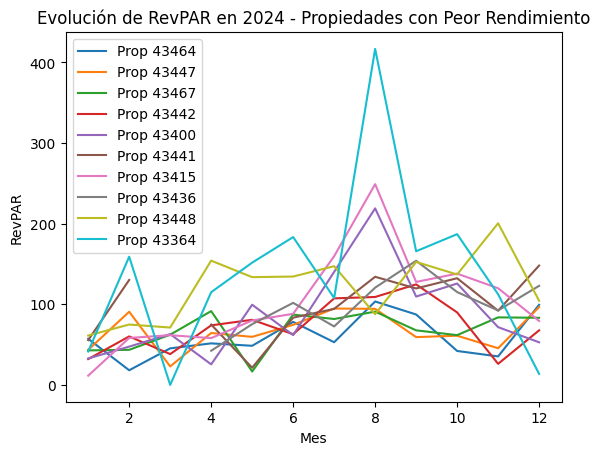

In [45]:
# Graficamos el RevPAR de las 10 peores propiedades
for prop_id in top_10_peores['PropertyId']:
    subset = data_2024[data_2024['PropertyId'] == prop_id]
    plt.plot(subset['Month'], subset['RevPAR'], label=f'Prop {prop_id}')

plt.xlabel('Mes')
plt.ylabel('RevPAR')
plt.title('Evolución de RevPAR en 2024 - Propiedades con Peor Rendimiento')
plt.legend()
plt.show()

Relacionamos con otros factores
Si contamos con datos adicionales como reseñas, comentarios de clientes o ubicación, se podrían integrarlos para encontrar patrones comunes entre estas propiedades de bajo rendimiento.

●	Recomendar acciones para mejorar la ocupación y ADR.

📉 Factores comunes en propiedades con bajo rendimiento:

- Es fundamental identificar patrones comunes entre las propiedades con bajo desempeño, considerando:

- Factores externos: crisis económicas, estacionalidad, restricciones sanitarias o de movilidad.

- Ubicación: zonas con alta competencia directa pueden dificultar la diferenciación.

- Eventos: ausencia de eventos próximos que atraigan visitantes o turismo.

- Tendencias del mercado: cambios en la demanda o comportamientos del consumidor.

- Opiniones de huéspedes: comentarios negativos o baja calificación en reseñas.
  
🔍 Estrategias para mejorar la Ocupación y la Tarifa Promedio Diaria (ADR):

- Aplicar descuentos en períodos de baja demanda, para reservas anticipadas o en días de semana.

- Implementar incrementos de tarifa progresivos durante períodos de alta demanda.

- Optimizar precios por segmento de cliente y estacionalidad.

- Ofrecer tarifas especiales para:

    - Grupos

    - Estancias prolongadas

    - Huéspedes frecuentes

- Mejorar la visibilidad en OTAs (plataformas de reservas online) y fomentar reseñas positivas de los huéspedes.

Descargamos datasets para utilizar en un dashboard

In [46]:
#datos_2024.to_csv('meta_nueva.csv', index=False) #KPI's, Mejores y Peores propiedades, 

In [47]:
#rendimiento_anual.to_csv('rendimiento_anual.csv', index=False)

In [48]:
forecast_final.to_csv('proyecciones.csv', index=False)

In [49]:
#resultados_elasticidad_df.to_csv('elasticidad.csv', index=False)

In [50]:
# peores_propiedades_umbral.to_csv('peores_prop.csv', index=False)